# 💻 PC Setup

In [32]:
!nvidia-smi

Wed May 22 15:53:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             11W /  120W |    3006MiB /   6144MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🧪 PIP INSTALL
Instalar pacotes: Autodistill, GroundedDINO, YOLOv8, Supervision e Roboflow


In [9]:
%pip install -q \
autodistill \
autodistill-grounding-dino \
autodistill-yolov8 \
supervision==0.9.0 \
roboflow 

Note: you may need to restart the kernel to use updated packages.


# 🗂️ IMPORT
**NOTE**: Bibliotecas principais como autodistill (CaptionOntology, GroundedDINO e YOLOv8) para lidar com rotulagem automatica e detecção de objetos


In [10]:
import os
import cv2
import random
import shutil
import supervision as sv
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO
from IPython.display import Image

# 🖼️ PREPARANDO DADOS

Vizualizando o diretório principal `HOME`

In [12]:
HOME = os.getcwd()
print(HOME)

c:\Users\vitor\.vscode\scritps\autodistill_yolov8


### Escolher aleatoriamente as imagens
Uma quantidade específica de imagens é selecionada aleatoriamente da pasta `total_images` e copiada para a pasta `images`

In [36]:
def copiar_imagens_aleatorias(pasta_imagens, pasta_destino, qte):
    imagens_disponiveis = os.listdir(pasta_imagens)

    if len(imagens_disponiveis) < qte:
        print("A pasta não contém imagens suficientes")
        return

    imagens_selecionadas = random.sample(imagens_disponiveis, qte)

    for imagem in imagens_selecionadas:
        caminho_imagem_origem = os.path.join(pasta_imagens, imagem)
        caminho_imagem_destino = os.path.join(pasta_destino, imagem)
        shutil.copy(caminho_imagem_origem, caminho_imagem_destino)

    print(f"{qte} imagens selecionadas e copiadas com sucesso")


pasta_imagens = "C:/Users/vitor/.vscode/scritps/autodistill_yolov8/total_images"  # diretorio com todas as imagens do dataset
pasta_destino = "C:/Users/vitor/.vscode/scritps/autodistill_yolov8/images"        # diretorio com as imagens selecionadas aleatoriamente
quantidade_imagens = 1000                                                         # definir quantidade de imagens escolhidas

copiar_imagens_aleatorias(pasta_imagens, pasta_destino, quantidade_imagens)

1000 imagens selecionadas e copiadas com sucesso


### Exibir amostra de imagem não rotulada

In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images"    # diretorio de imagens 
DATASET_DIR_PATH = f"{HOME}/dataset" # diretorio de treinamento do dataset

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png"])

print(f"Quantidades de imagens: {len(image_paths)}")

In [ ]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (25, 15)

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

# 🪄 AUTODISTILL

### Definir ontologia

**Ontologia** - uma Ontologia define como seu Modelo Base é solicitado, o que seu Conjunto de Dados descreverá e o que seu Modelo Alvo irá prever. Uma ontologia simples é a CaptionOntology que solicita um modelo base com legendas de texto e as mapeia para nomes de classes.
- Uma ontologia em Computação é um modelo de dados que representa um conjunto de conceitos dentro de um domínio e os relacionamentos entre estes.

In [37]:
"""
  Ontology: como o modelo base é solicitado
  Descreve o que voce realmente ve no conjunto de dados e no que deseja treinar
  seu modelo destino

  Lancar os prompts e classes para gerar as mascaras de segmentacao
    -> (prompt : class)
"""

# Definir as classes 
ontology=CaptionOntology({
  "car" : "car",
  "motorcycle" : "motorcycle",
  "pedestrian " : "pedestrian",
  "traffic sign" : "traffic sign"
})

### Iniciar modelo base e rótulo automático
Inicializa o modelo base `GroundingDINO` e rotula o conjunto de dados

In [38]:
base_model = GroundingDINO(ontology=ontology)   # Modelo base: GroundingDINO
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,                # Pasta de entrada das imagens
    extension=".png",                           # Extensão dos arquivos de imagem (.png)
    output_folder=DATASET_DIR_PATH              # Pasta de saída para os dados rotulados
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling c:\Users\vitor\.vscode\scritps\autodistill_yolov8/images\20190401145936_camera_frontcenter_000000279.png:   0%|          | 0/1000 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling c:\Users\vitor\.vscode\scritps\autodistill_yolov8/images\20190401145936_camera_sideright_000022324.png: 100%|██████████| 1000/1000 [45:47<00:00,  2.75s/it] 


Labeled dataset created - ready for distillation.


### Exibir amostra do conjunto de dados

**Conjunto de dados/dataset** - dados rotulados automaticamente que pode ser usado para treinar um modelo de destino, como por exemplo YOLOv8. É a saída gerada por um Modelo Base.

In [39]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"     # dados de rotulagem das imagens treinadas
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"          # imagens de treino rotuladas
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"                    # arquivo formato YOLO.yaml

**NOTA**: a quantidade de imagens total é dividida em `train` e `valid`

In [40]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

print(f"Quantidade de imagens de treinamento: {len(dataset)}") 

Quantidade de imagens de treinamento: 800


### Exibir amostra de imagem rotulada

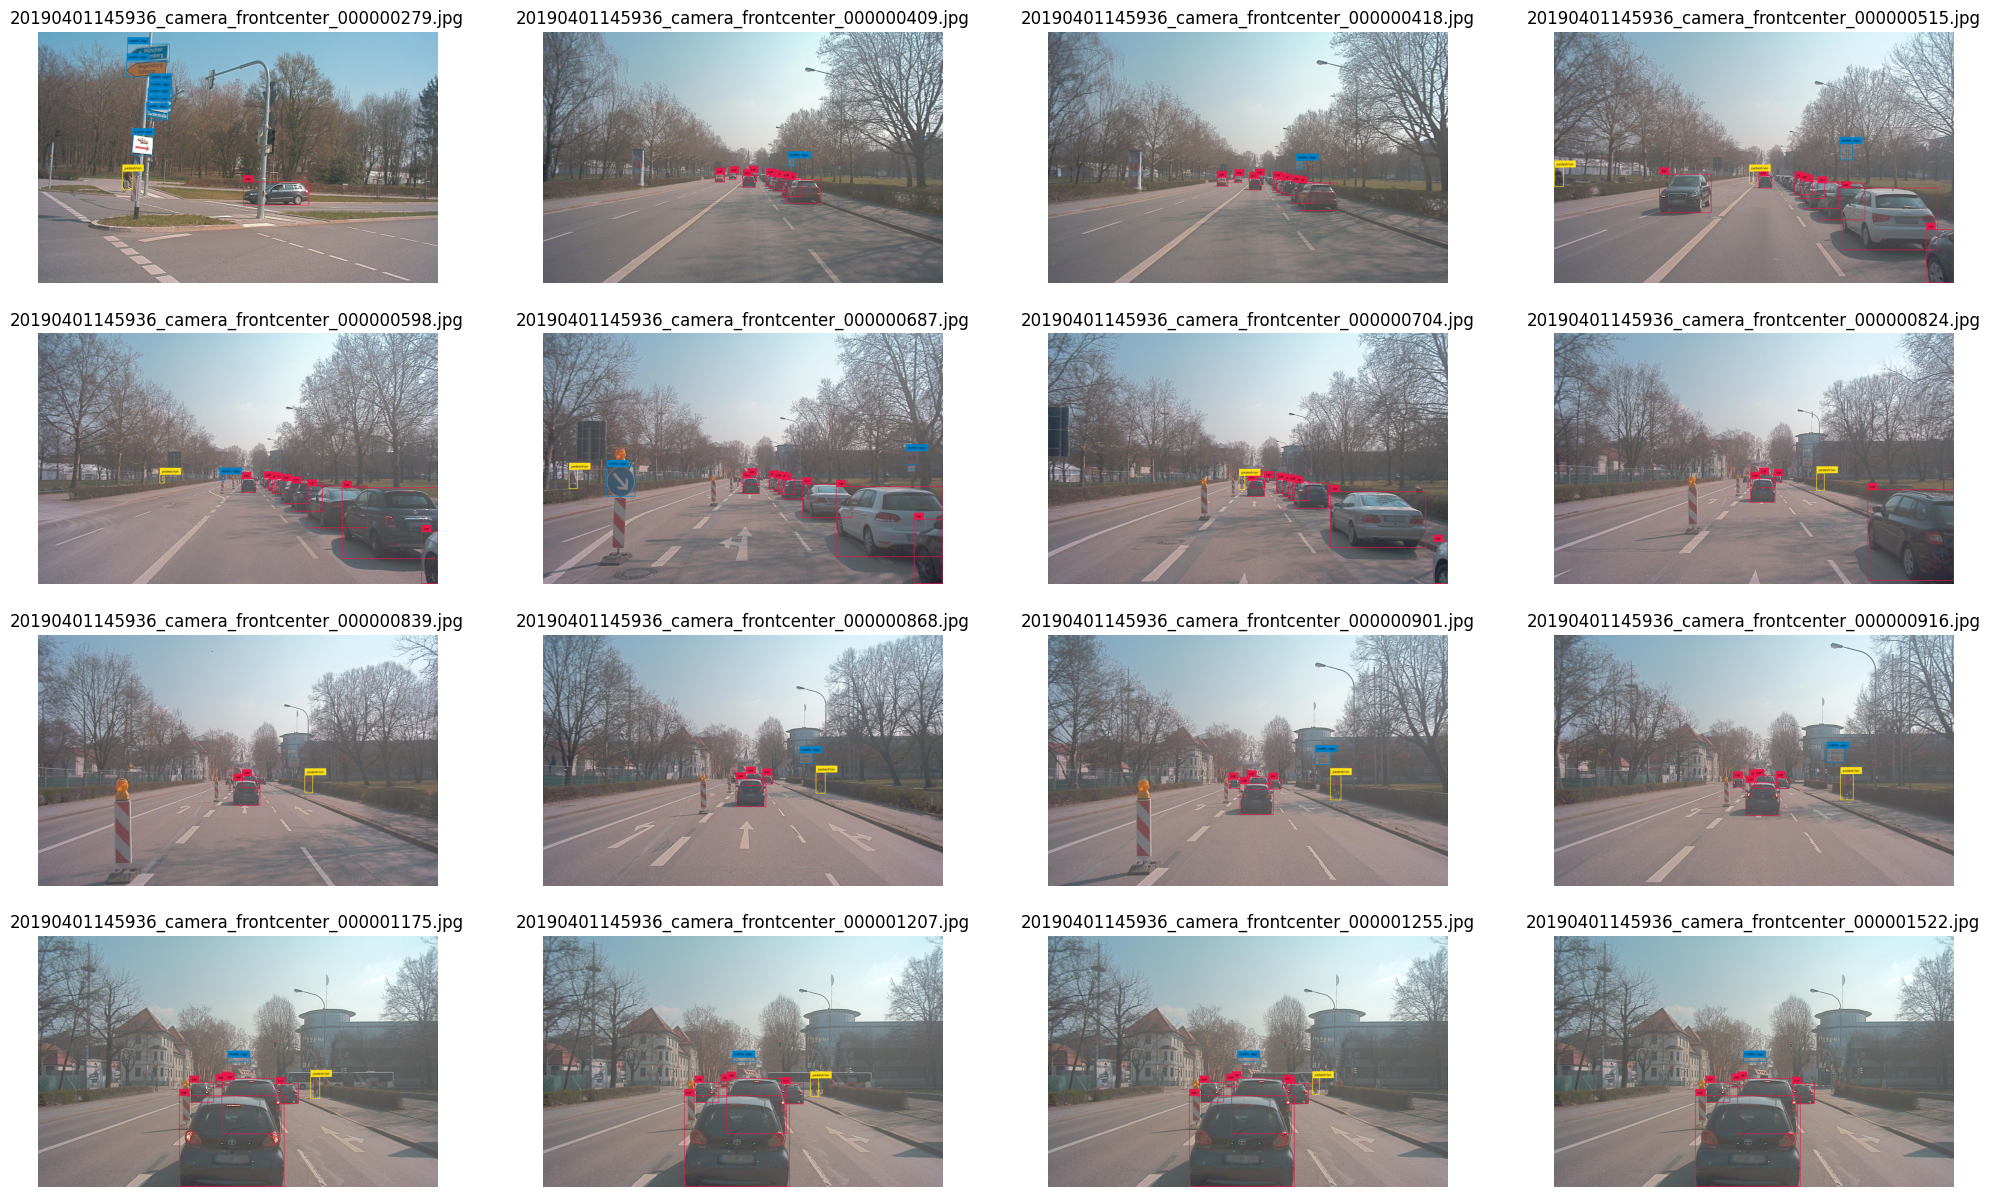

In [42]:
"""
    Exemplos de imagens; Loop for em execucao com todos os parametros que criam essa imagens com as caixas delimitadoras; 
    e tambem dados demograficos para tracar nossa grade de imagens.
"""

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (25, 15)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

# 📈 Logger

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {HOME}/runs/detect

# 🚘YOLOV8


### Treinamento do modelo
**Modelo de destino** – é um modelo supervisionado que consome um conjunto de dados e gera um modelo destilado que está pronto para implantação. Os modelos de destino geralmente são pequenos, rápidos e ajustados para executar muito bem uma tarefa específica (mas não generalizam muito além das informações descritas em seu conjunto de dados).

**NOTA**: A interface de linha de comando YOLO (CLI) permite comandos simples de linha única sem a necessidade de um ambiente Python. CLI não requer personalização ou código Python . Podes simplesmente executar todas as tarefas a partir do terminal com o comando yolo

Ultralytics yolo utiliza a seguinte sintaxe:
```python
  yolo TASK MODE ARGS

  Where   TASK (optional) is one of [detect, segment, classify]
          MODE (required) is one of [train, val, predict, export, track]
          ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
```

### Treinando o modelo

In [55]:
!yolo \
task=detect \
mode=train \
model=yolov8n.pt \
data={DATASET_DIR_PATH}/data.yaml \
epochs=30 \
batch=2 \
imgsz=640 \
device=0 \
hsv_h=0.3 \
hsv_s=0.5 \
hsv_v=0.5 \
fliplr=0.5 \
degrees=10 \
translate=0.1 \
scale=0.5 \
mosaic=1 \
name="yolov8n_30ep_200img_train"

Ultralytics YOLOv8.0.81  Python-3.12.3 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\vitor\.vscode\scritps\autodistill_yolov8/dataset/data.yaml, epochs=30, patience=50, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8n_30ep_200img_train, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, for

### Validando o modelo de treinamento
Fornece um conjunto robusto de ferramentas e métricas para avaliar o desempenho dos teus modelos de deteção de objectos
- Precisão e Ajuste de hiperparâmetros

**NOTA**: Os arquivos de treinamento foram gerados e armazenados no diretorio `runs`.

In [58]:
!yolo \
task=detect \
mode=val \
model={HOME}/runs/detect/yolov8n_30ep_200img_train/weights/best.pt \
data={DATASET_DIR_PATH}/data.yaml \
name="yolov8n_30ep_200img_val"

Ultralytics YOLOv8.0.81  Python-3.12.3 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

val: Scanning C:\Users\vitor\.vscode\scritps\autodistill_yolov8\dataset\valid\labels.cache... 200 images, 10 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
val: Scanning C:\Users\vitor\.vscode\scritps\autodistill_yolov8\dataset\valid\labels.cache... 200 images, 10 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]
        

### Exibir resultados de treinamento e validação
**NOTA**: Os arquivos dos resultados de treinamento e validação foram gerados e armazenados no diretorio `runs\detect\testx`, onde x é numero de 1 a n.

**Métricas de treinamento**

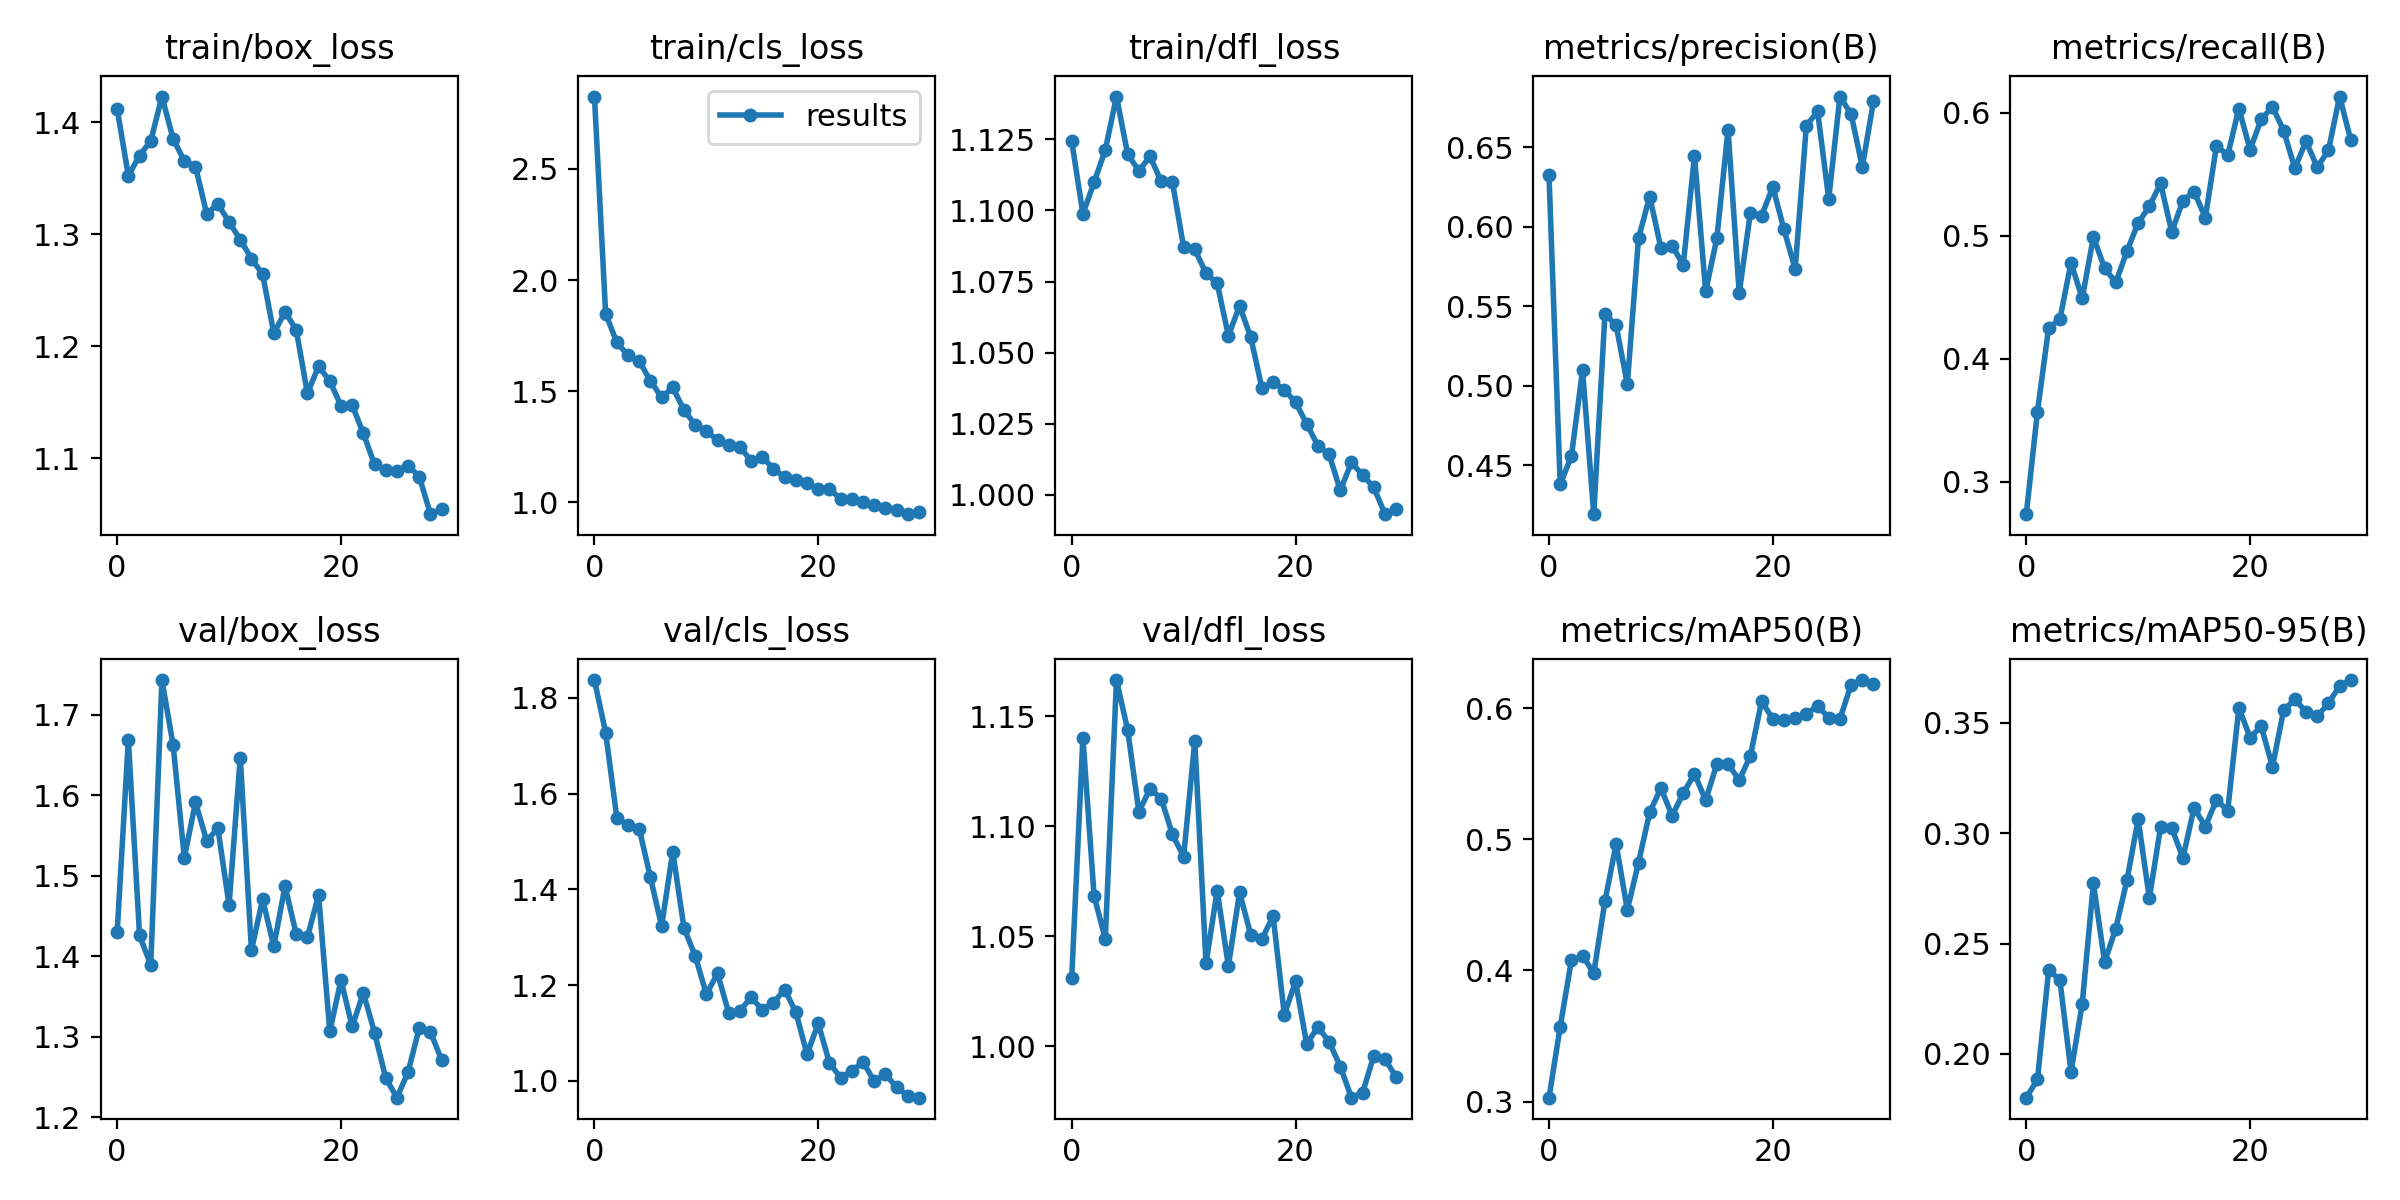

In [16]:
Image(filename=f'{HOME}/runs/detect/yolov8n_30ep_200img_train/results.png', width=800)

**Matriz de confusão**

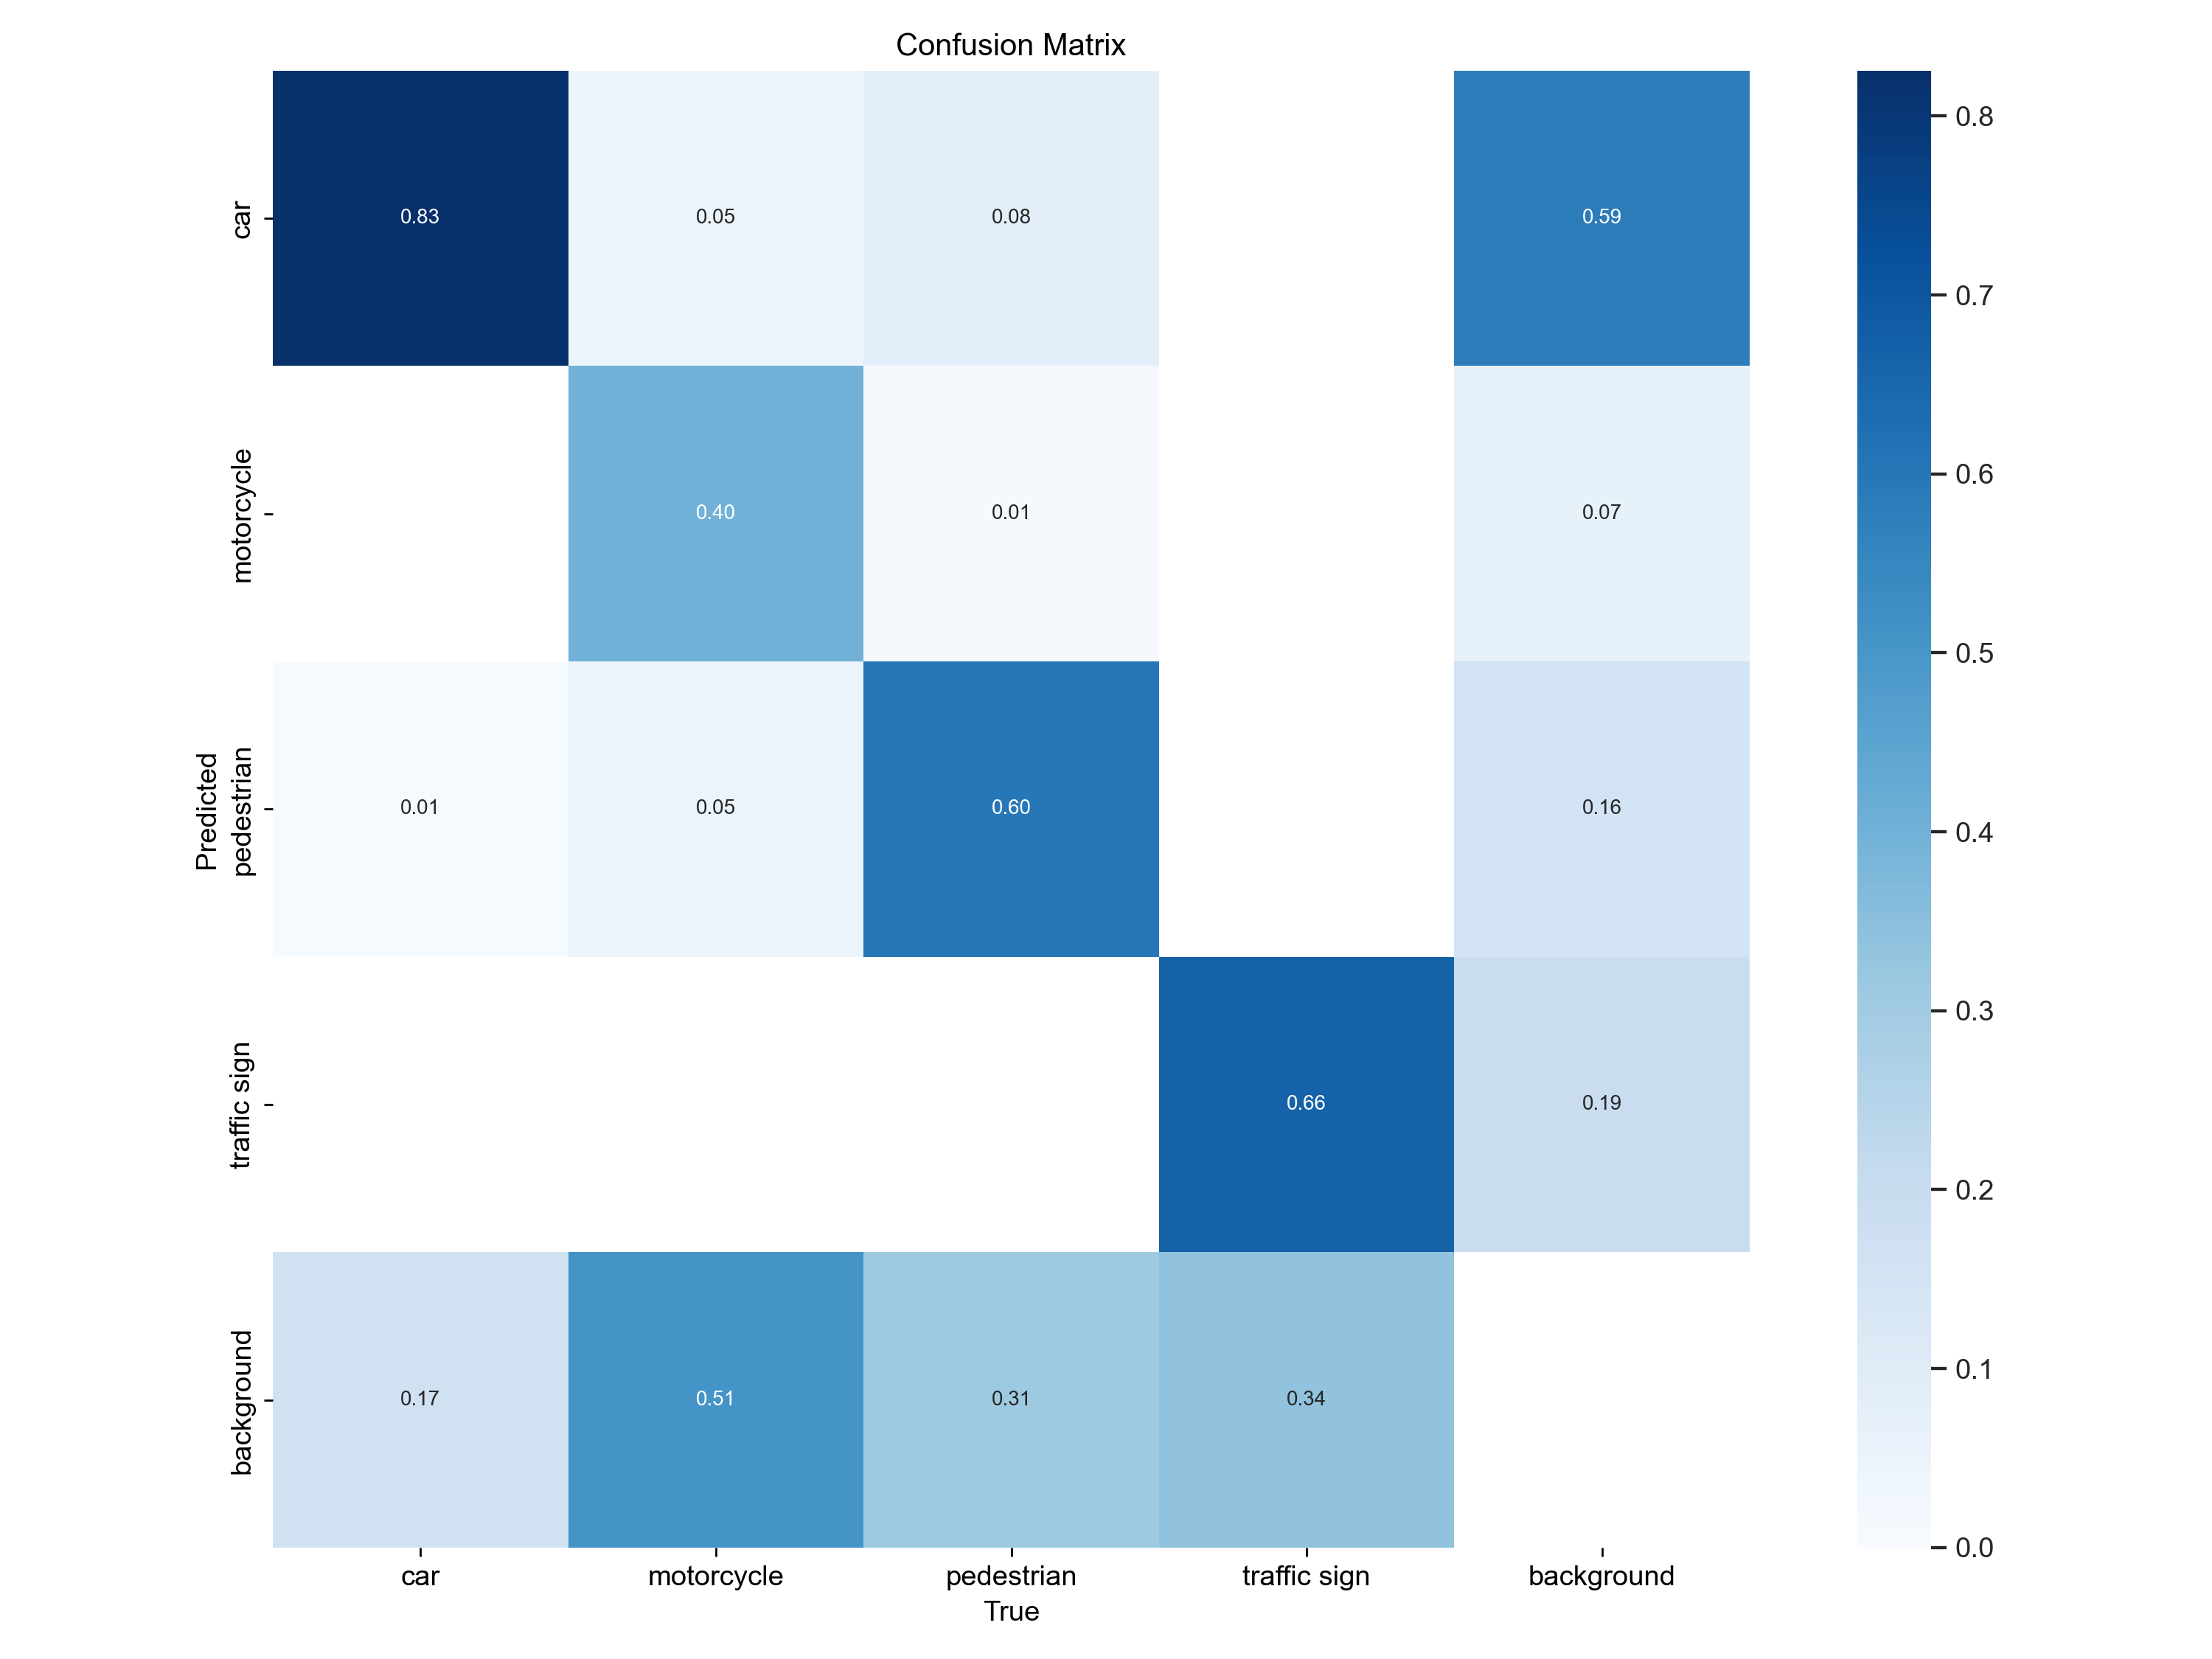

In [15]:
Image(filename=f'{HOME}/runs/detect/yolov8n_30ep_200img_train/confusion_matrix.png', width=800)

**Imagens validadas**

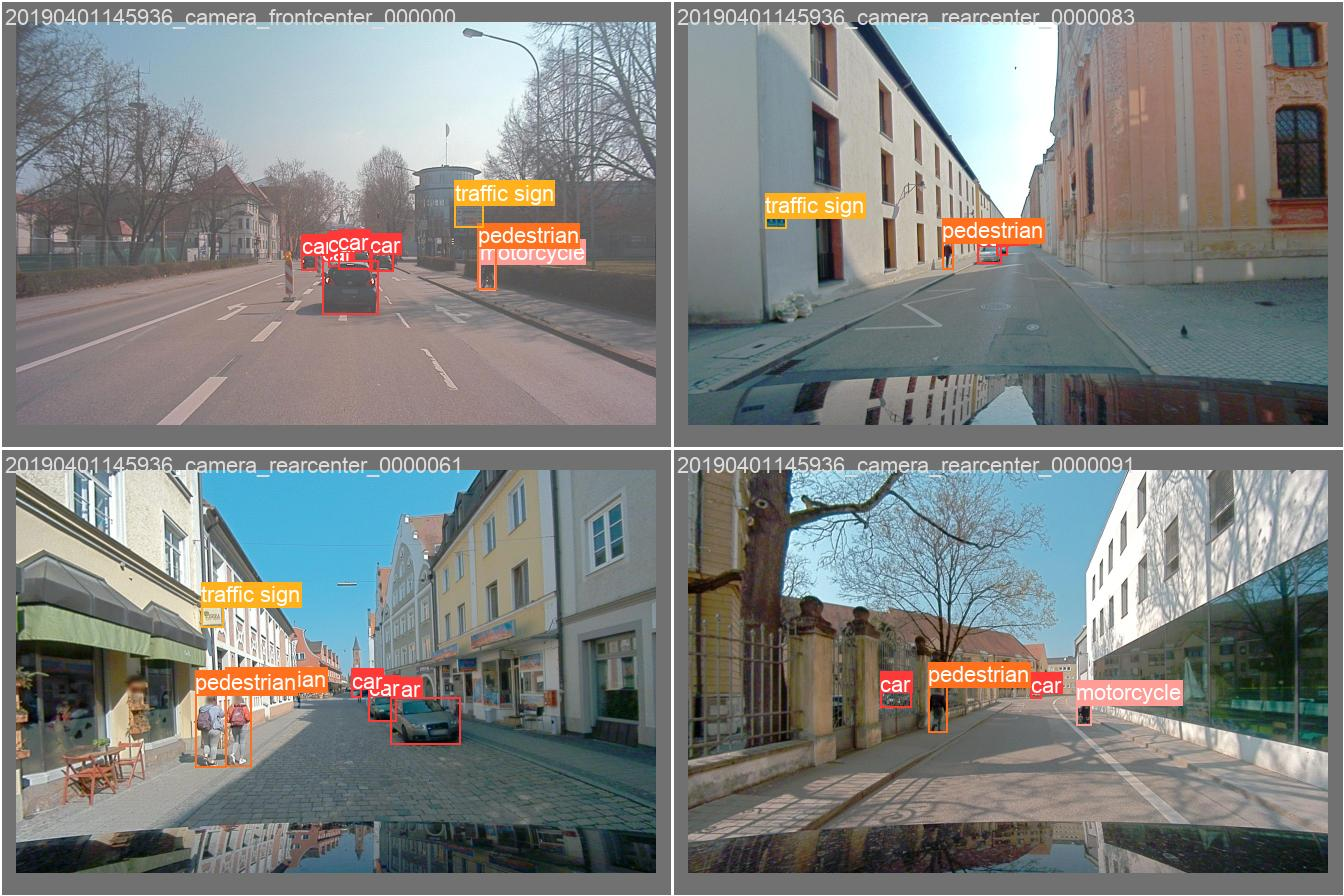

In [18]:
Image(filename=f'{HOME}/runs/detect/yolov8n_30ep_200img_train/val_batch0_labels.jpg', width=800)